In [2]:
# Import libraries
import pandas as pd
from IPython.display import display, HTML
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, roc_curve, auc
from imblearn.over_sampling import SMOTE
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# Load dataset
file_path = '/Users/Erlemico/Downloads/breastCancer.csv'
df = pd.read_csv(file_path)

# Tampilkan tabel sebagai HTML
display(HTML(df.to_html()))

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990,10.38,122.80,1001.0,0.11840,0.27760,0.300100,0.147100,0.2419,0.07871,1.0950,0.9053,8.5890,153.400,0.006399,0.049040,0.053730,0.015870,0.030030,0.006193,25.380,17.33,184.60,2019.0,0.16220,0.66560,0.711900,0.265400,0.4601,0.11890,NaN
1,842517,M,20.570,17.77,132.90,1326.0,0.08474,0.07864,0.086900,0.070170,0.1812,0.05667,0.5435,0.7339,3.3980,74.080,0.005225,0.013080,0.018600,0.013400,0.013890,0.003532,24.990,23.41,158.80,1956.0,0.12380,0.18660,0.241600,0.186000,0.2750,0.08902,NaN
2,84300903,M,19.690,21.25,130.00,1203.0,0.10960,0.15990,0.197400,0.127900,0.2069,0.05999,0.7456,0.7869,4.5850,94.030,0.006150,0.040060,0.038320,0.020580,0.022500,0.004571,23.570,25.53,152.50,1709.0,0.14440,0.42450,0.450400,0.243000,0.3613,0.08758,NaN
3,84348301,M,11.420,20.38,77.58,386.1,0.14250,0.28390,0.241400,0.105200,0.2597,0.09744,0.4956,1.1560,3.4450,27.230,0.009110,0.074580,0.056610,0.018670,0.059630,0.009208,14.910,26.50,98.87,567.7,0.20980,0.86630,0.686900,0.257500,0.6638,0.17300,NaN
4,84358402,M,20.290,14.34,135.10,1297.0,0.10030,0.13280,0.198000,0.104300,0.1809,0.05883,0.7572,0.7813,5.4380,94.440,0.011490,0.024610,0.056880,0.018850,0.017560,0.005115,22.540,16.67,152.20,1575.0,0.13740,0.20500,0.400000,0.162500,0.2364,0.07678,NaN
5,843786,M,12.450,15.70,82.57,477.1,0.12780,0.17000,0.157800,0.080890,0.2087,0.07613,0.3345,0.8902,2.2170,27.190,0.007510,0.033450,0.036720,0.011370,0.021650,0.005082,15.470,23.75,103.40,741.6,0.17910,0.52490,0.535500,0.174100,0.3985,0.12440,NaN
6,844359,M,18.250,19.98,119.60,1040.0,0.09463,0.10900,0.112700,0.074000,0.1794,0.05742,0.4467,0.7732,3.1800,53.910,0.004314,0.013820,0.022540,0.010390,0.013690,0.002179,22.880,27.66,153.20,1606.0,0.14420,0.25760,0.378400,0.193200,0.3063,0.08368,NaN
7,84458202,M,13.710,20.83,90.20,577.9,0.11890,0.16450,0.093660,0.059850,0.2196,0.07451,0.5835,1.3770,3.8560,50.960,0.008805,0.030290,0.024880,0.014480,0.014860,0.005412,17.060,28.14,110.60,897.0,0.16540,0.36820,0.267800,0.155600,0.3196,0.11510,NaN
8,844981,M,13.000,21.82,87.50,519.8,0.12730,0.19320,0.185900,0.093530,0.2350,0.07389,0.3063,1.0020,2.4060,24.320,0.005731,0.035020,0.035530,0.012260,0.021430,0.003749,15.490,30.73,106.20,739.3,0.17030,0.54010,0.539000,0.206000,0.4378,0.10720,NaN
9,84501001,M,12.460,24.04,83.97,475.9,0.11860,0.23960,0.227300,0.085430,0.2030,0.08243,0.2976,1.5990,2.0390,23.940,0.007149,0.072170,0.077430,0.014320,0.017890,0.010080,15.090,40.68,97.65,711.4,0.18530,1.05800,1.105000,0.221000,0.4366,0.20750,NaN


In [3]:
# OPTIONAL: Check data info
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [4]:
# Preprocessing: Menghapus kolom yang tidak relevan (Unnamed: 32)
df.drop(columns=['Unnamed: 32'], inplace=True)

In [5]:
# OPTIONAL: Display statistical summary
print(df.describe())

                 id  radius_mean  texture_mean  perimeter_mean    area_mean  \
count  5.690000e+02   569.000000    569.000000      569.000000   569.000000   
mean   3.037183e+07    14.127292     19.289649       91.969033   654.889104   
std    1.250206e+08     3.524049      4.301036       24.298981   351.914129   
min    8.670000e+03     6.981000      9.710000       43.790000   143.500000   
25%    8.692180e+05    11.700000     16.170000       75.170000   420.300000   
50%    9.060240e+05    13.370000     18.840000       86.240000   551.100000   
75%    8.813129e+06    15.780000     21.800000      104.100000   782.700000   
max    9.113205e+08    28.110000     39.280000      188.500000  2501.000000   

       smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813     

In [6]:
df.isnull().sum()

id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

In [7]:
# Memeriksa duplikat berdasarkan semua kolom
print("Jumlah duplikat:", df.duplicated().sum())

# Menghapus duplikat jika ditemukan
df = df.drop_duplicates()
print("Jumlah data setelah menghapus duplikat:", df.shape[0])

Jumlah duplikat: 0
Jumlah data setelah menghapus duplikat: 569


In [8]:
# Handling missing values using modus (mode)
# Mode: mengambil nilai yang paling sering muncul
modus = df['diagnosis'].mode()[0]  # Mengambil nilai modus
df['diagnosis'] = df['diagnosis'].fillna(modus)  # Mengisi missing values dengan modus

# Print modus
print(f"Modus dari kolom 'diagnosis' adalah: {modus}")

Modus dari kolom 'diagnosis' adalah: B


In [9]:
# Memeriksa duplikat berdasarkan kolom tertentu, misalnya "id"
print("Jumlah duplikat berdasarkan 'id':", df.duplicated(subset=['id']).sum())

# Menghapus duplikat berdasarkan kolom tertentu
df = df.drop_duplicates(subset=['id'])
print("Jumlah data setelah menghapus duplikat berdasarkan 'id':", df.shape[0])

Jumlah duplikat berdasarkan 'id': 0
Jumlah data setelah menghapus duplikat berdasarkan 'id': 569



Jumlah nilai kosong per kolom:
id                         0
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64

Distribusi diagnosis:
diag

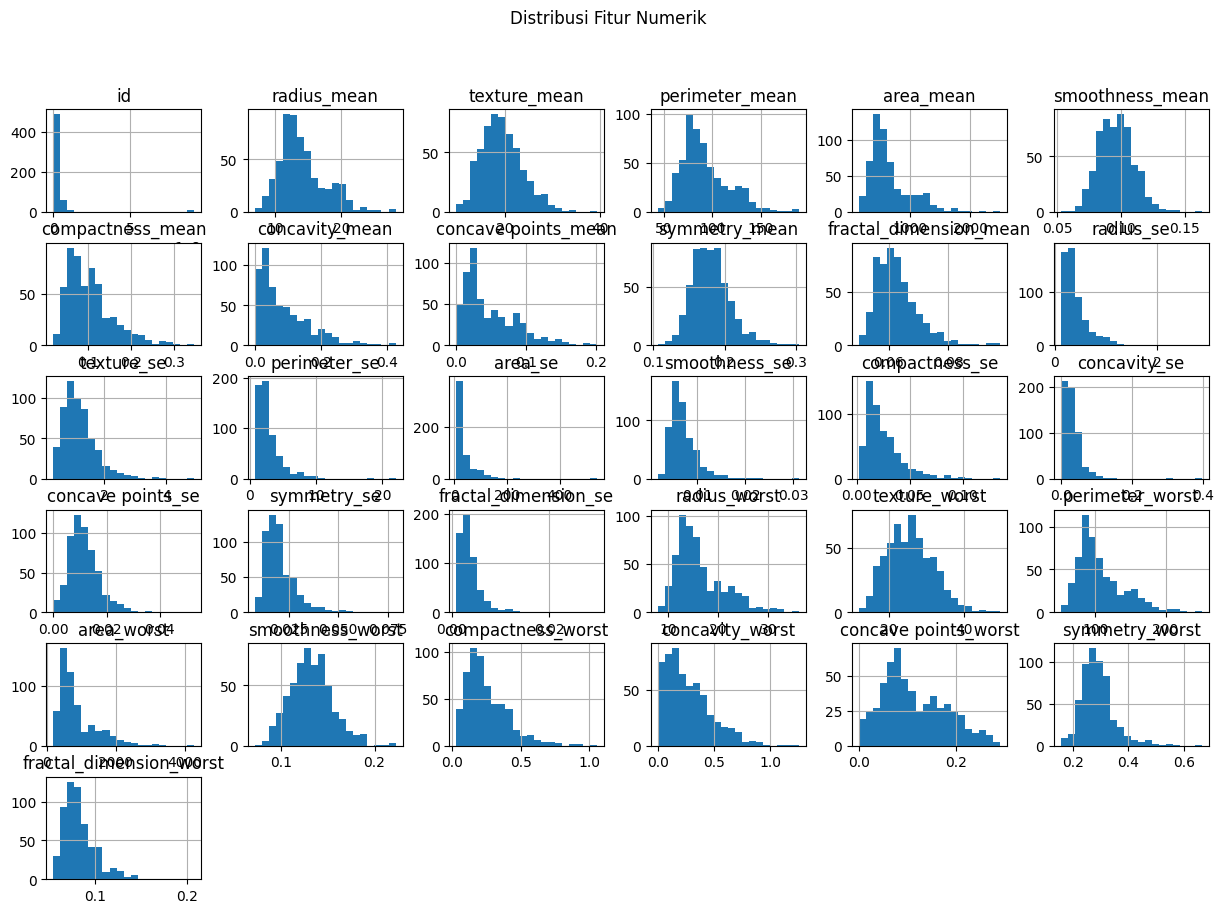

In [10]:
# Menampilkan jumlah nilai kosong
print("\nJumlah nilai kosong per kolom:")
print(df.isnull().sum())

# Distribusi diagnosis
print("\nDistribusi diagnosis:")
print(df['diagnosis'].value_counts())

# Visualisasi histogram untuk setiap fitur numerik
import matplotlib.pyplot as plt

df.hist(bins=20, figsize=(15, 10))
plt.suptitle('Distribusi Fitur Numerik')
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Normalisasi fitur numerik
numerical_features = [
    "radius_mean", "texture_mean", "perimeter_mean", "area_mean",
    "smoothness_mean", "compactness_mean", "concavity_mean",
    "concave points_mean", "symmetry_mean", "fractal_dimension_mean",
    "radius_se", "texture_se", "perimeter_se", "area_se",
    "smoothness_se", "compactness_se", "concavity_se", "concave points_se"
]

scaler = MinMaxScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

# Menampilkan data yang telah dinormalisasi
print("\nData setelah normalisasi:")
print(df[numerical_features])


Data setelah normalisasi:
     radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0       0.521037      0.022658        0.545989   0.363733         0.593753   
1       0.643144      0.272574        0.615783   0.501591         0.289880   
2       0.601496      0.390260        0.595743   0.449417         0.514309   
3       0.210090      0.360839        0.233501   0.102906         0.811321   
4       0.629893      0.156578        0.630986   0.489290         0.430351   
..           ...           ...             ...        ...              ...   
564     0.690000      0.428813        0.678668   0.566490         0.526948   
565     0.622320      0.626987        0.604036   0.474019         0.407782   
566     0.455251      0.621238        0.445788   0.303118         0.288165   
567     0.644564      0.663510        0.665538   0.475716         0.588336   
568     0.036869      0.501522        0.028540   0.015907         0.000000   

     compactness_mean  concavity_mea

In [12]:
# Encode kolom 'diagnosis' menjadi numerik (M=1, B=0)
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

In [13]:
# Pisahkan fitur (X) dan target (y)
X = df.drop(columns=['diagnosis'])  # Semua fitur kecuali 'diagnosis'
y = df['diagnosis']  # Target: diagnosis (M=1, B=0)

In [14]:
# Address class imbalance (SMOTE)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

In [15]:
# Bagi dataset menjadi 80% data latih dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [16]:
# Baseline Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# Evaluasi model dasar
y_pred = rf_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy Score: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))

Accuracy Score: 0.95

Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95        69
   Malignant       0.97      0.93      0.95        74

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



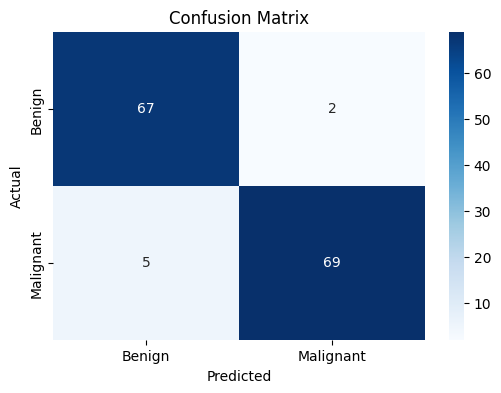

In [17]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [18]:
# Feature Importances
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                    Feature  Importance
24               area_worst    0.147687
23          perimeter_worst    0.136522
21             radius_worst    0.127726
28     concave points_worst    0.082547
8       concave points_mean    0.073773
3            perimeter_mean    0.059657
4                 area_mean    0.058558
7            concavity_mean    0.044193
14                  area_se    0.042526
27          concavity_worst    0.040208
1               radius_mean    0.024595
13             perimeter_se    0.019865
26        compactness_worst    0.017977
6          compactness_mean    0.015386
25         smoothness_worst    0.012418
22            texture_worst    0.010540
2              texture_mean    0.010468
29           symmetry_worst    0.009538
17             concavity_se    0.007142
11                radius_se    0.005972
16           compactness_se    0.005650
20     fractal_dimension_se    0.005560
10   fractal_dimension_mean    0.005543
0                 

In [19]:
# Hyperparameter Tuning with GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Parameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,  # 5-fold cross-validation
    scoring='accuracy',
    n_jobs=-1,  # Use all processors
    verbose=2  # Log progress
)

# Fit the model
try:
    grid_search.fit(X_train, y_train)
    # Print the best parameters
    print(f"Best Parameters: {grid_search.best_params_}")
except Exception as e:
    print(f"Error during GridSearch: {str(e)}")

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   0.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=5, n_estimators=300; tot

In [25]:
# Model with best parameters
best_rf_model = grid_search.best_estimator_
best_rf_model.fit(X_train, y_train)

# Evaluate the tuned model
y_pred_best = best_rf_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Tuned Model Accuracy: {accuracy_best:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=['Benign', 'Malignant']))

Tuned Model Accuracy: 0.97

Classification Report:
              precision    recall  f1-score   support

      Benign       0.96      0.97      0.96        69
   Malignant       0.97      0.96      0.97        74

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.97       143
weighted avg       0.97      0.97      0.97       143



In [26]:
# Cross-Validation
cv_scores = cross_val_score(best_rf_model, X, y, cv=10, scoring='accuracy')
print(f"Cross-Validation Accuracy: {cv_scores.mean():.2f} ± {cv_scores.std():.2f}")

Cross-Validation Accuracy: 0.96 ± 0.03


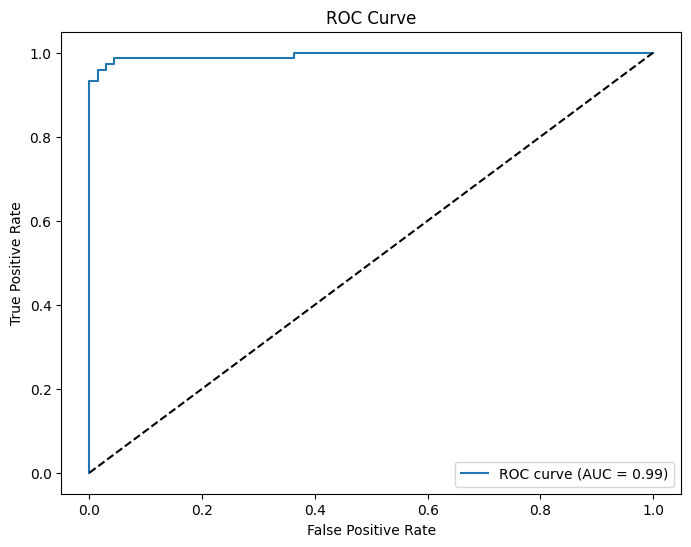

In [27]:
# ROC-AUC
y_prob = best_rf_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()

In [30]:
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nModel: {model.__class__.__name__}")
    print(f"Accuracy: {accuracy:.2f}")
    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Benign', 'Malignant']))
    return accuracy

In [31]:
# Random Forest
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_accuracy = evaluate_model(rf_model, X_train, X_test, y_train, y_test)


Model: RandomForestClassifier
Accuracy: 0.95
Classification Report:
              precision    recall  f1-score   support

      Benign       0.93      0.97      0.95        69
   Malignant       0.97      0.93      0.95        74

    accuracy                           0.95       143
   macro avg       0.95      0.95      0.95       143
weighted avg       0.95      0.95      0.95       143



In [43]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Decision Tree
dt_model = DecisionTreeClassifier(random_state=42)
dt_accuracy = evaluate_model(dt_model, X_train, X_test, y_train, y_test)


Model: DecisionTreeClassifier
Accuracy: 0.93
Classification Report:
              precision    recall  f1-score   support

      Benign       0.95      0.90      0.93        69
   Malignant       0.91      0.96      0.93        74

    accuracy                           0.93       143
   macro avg       0.93      0.93      0.93       143
weighted avg       0.93      0.93      0.93       143



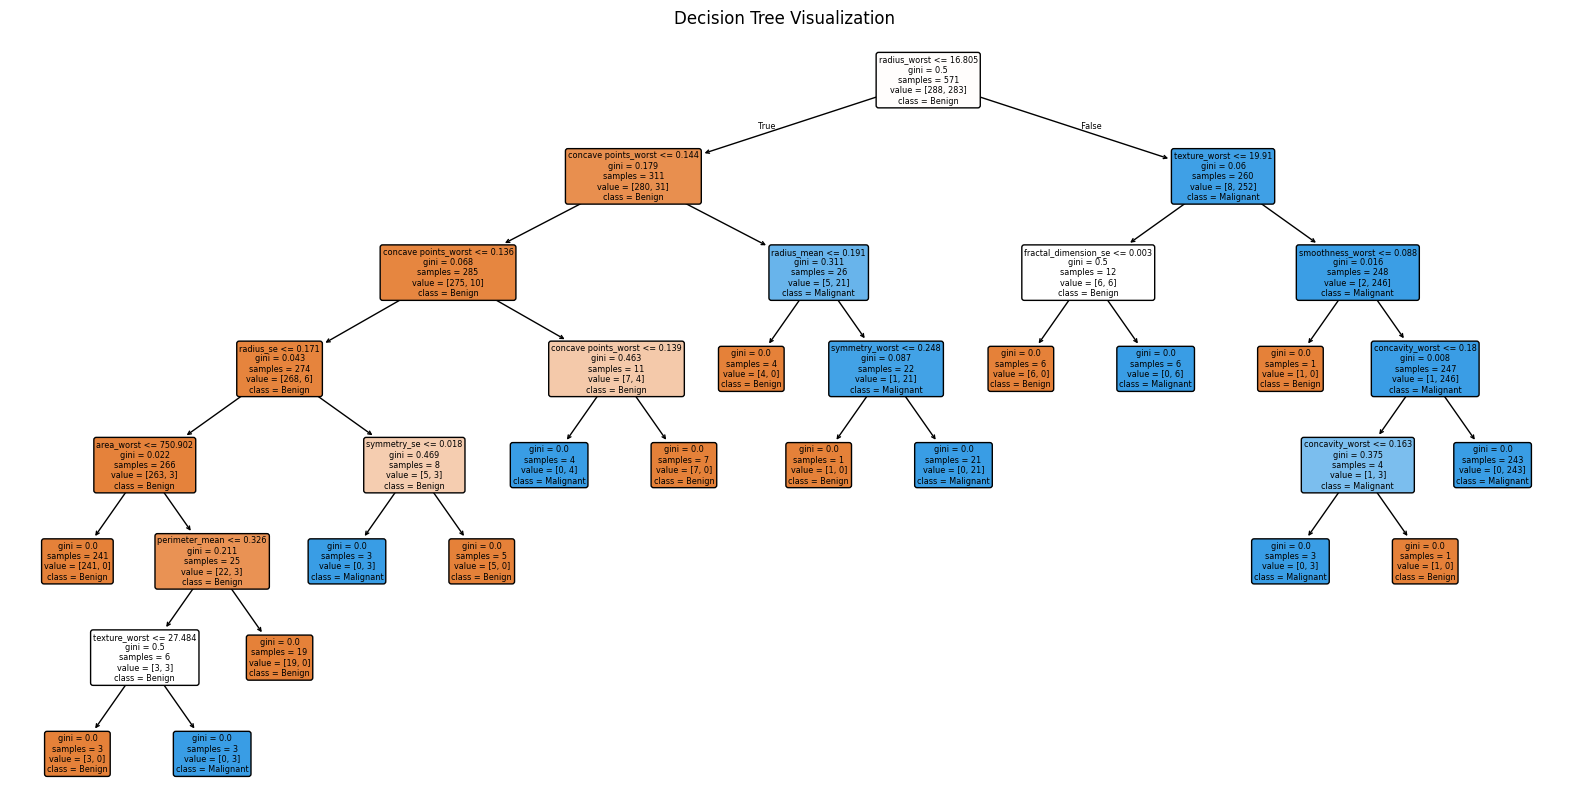

In [44]:
# Visualize Decision Tree
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X.columns, class_names=['Benign', 'Malignant'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

In [34]:
from sklearn.neighbors import KNeighborsClassifier

# K-Nearest Neighbors
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_accuracy = evaluate_model(knn_model, X_train, X_test, y_train, y_test)


Model: KNeighborsClassifier
Accuracy: 0.80
Classification Report:
              precision    recall  f1-score   support

      Benign       0.77      0.83      0.80        69
   Malignant       0.83      0.77      0.80        74

    accuracy                           0.80       143
   macro avg       0.80      0.80      0.80       143
weighted avg       0.80      0.80      0.80       143



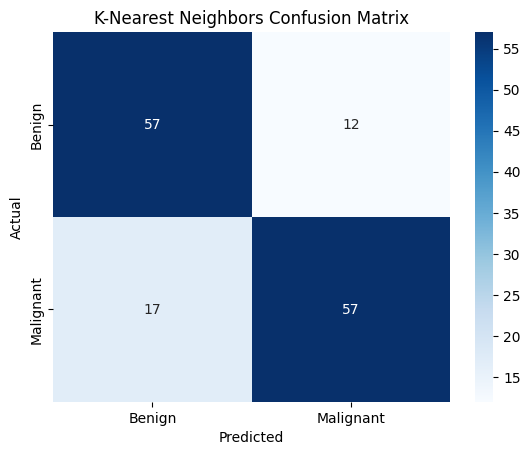

In [45]:
# Visualize K-Nearest Neighbors (Confusion Matrix)
y_pred_knn = knn_model.predict(X_test)
conf_matrix_knn = confusion_matrix(y_test, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="Blues", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("K-Nearest Neighbors Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [35]:
from sklearn.svm import SVC

# Support Vector Machine
svm_model = SVC(probability=True, random_state=42)
svm_accuracy = evaluate_model(svm_model, X_train, X_test, y_train, y_test)


Model: SVC
Accuracy: 0.53
Classification Report:
              precision    recall  f1-score   support

      Benign       0.51      0.87      0.64        69
   Malignant       0.64      0.22      0.32        74

    accuracy                           0.53       143
   macro avg       0.57      0.54      0.48       143
weighted avg       0.58      0.53      0.48       143



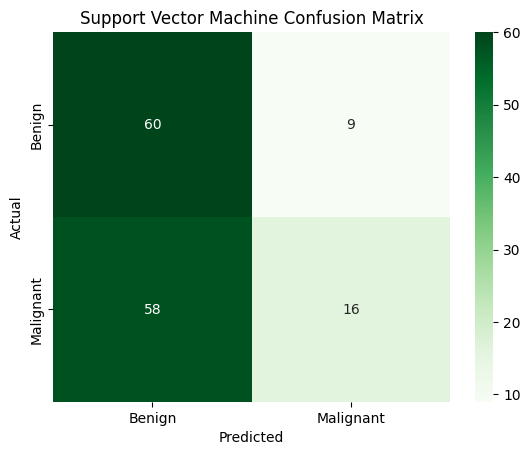

In [46]:
# Visualize Support Vector Machine (Confusion Matrix)
y_pred_svm = svm_model.predict(X_test)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(conf_matrix_svm, annot=True, fmt="d", cmap="Greens", xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.title("Support Vector Machine Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [38]:
from sklearn.cluster import KMeans

# K-Means (unsupervised clustering)
kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(X)
labels = kmeans_model.labels_

# Adjust labels to match target encoding (0 and 1)
if accuracy_score(y, labels) < 0.5:
    labels = 1 - labels
kmeans_accuracy = accuracy_score(y, labels)
print(f"\nModel: KMeans")
print(f"Accuracy: {kmeans_accuracy:.2f}")


Model: KMeans
Accuracy: 0.63


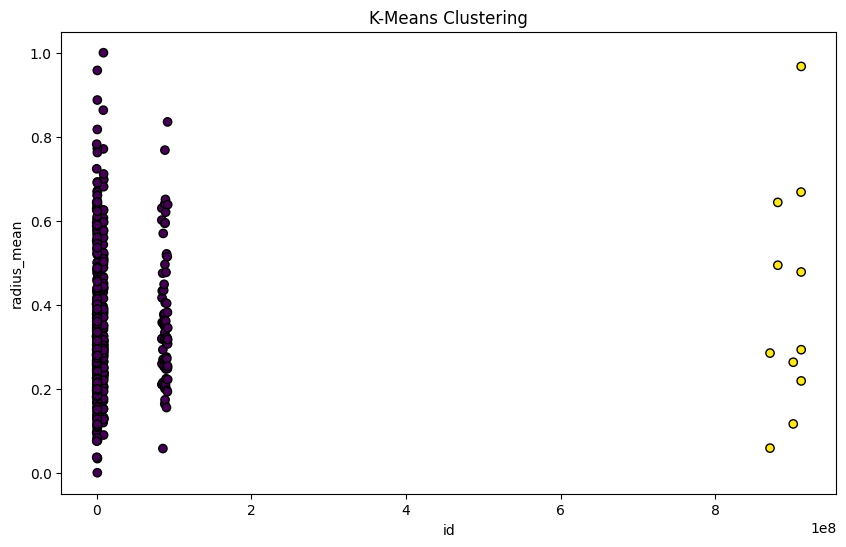

In [47]:
# Visualize K-Means Clustering
plt.figure(figsize=(10, 6))
plt.scatter(X.iloc[:, 0], X.iloc[:, 1], c=labels, cmap='viridis', marker='o', edgecolor='k')
plt.title("K-Means Clustering")
plt.xlabel(X.columns[0])
plt.ylabel(X.columns[1])
plt.show()

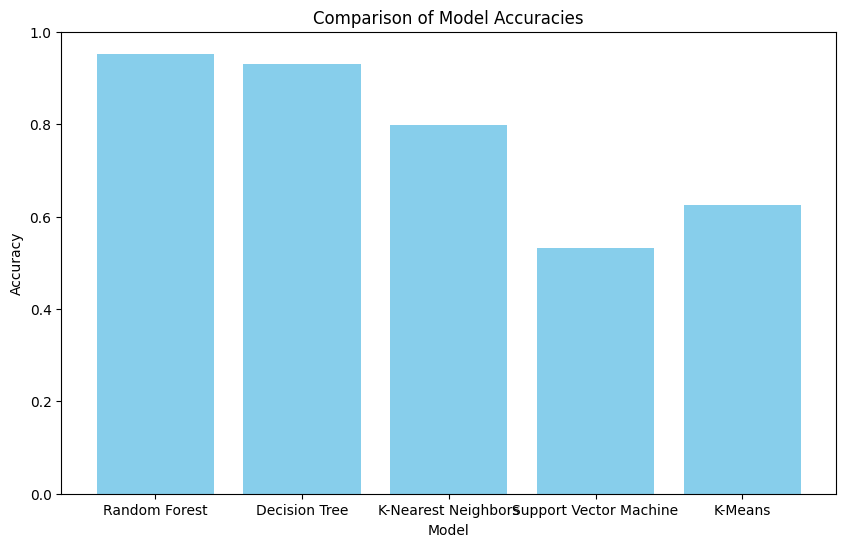

In [40]:
# Comparison of Models
model_accuracies = {
    'Random Forest': rf_accuracy,
    'Decision Tree': dt_accuracy,
    'K-Nearest Neighbors': knn_accuracy,
    'Support Vector Machine': svm_accuracy,
    'K-Means': kmeans_accuracy
}

# Plot comparison
plt.figure(figsize=(10, 6))
plt.bar(model_accuracies.keys(), model_accuracies.values(), color='skyblue')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(0, 1)
plt.show()